In [1]:
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from nim_env import NimEnv, OptimalPlayer
from helpers import *

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = NimEnv(seed = 3)


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#parameters
GAMMA = 0.99
buffer_size = 10000
BATCH_SIZE = 64
TARGET_UPDATE = 500

#Epsilon greedy : 
EPS_GREEDY = 0.5 #random.random()
print("epsilon greedy : ", EPS_GREEDY)

#-------------------------------- helpers DQN ----------------------------
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        random.seed()
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

def to_input(heaps):
    #change the format of the heaps so that it can be used as an input for the neural network. 
    init_state = torch.zeros(9, device = device)
    for i in range(3):
        state = bin(heaps[i])[2:]
        j = 0 
        while j < len(state):
            init_state[i*3 + 2 - j] = np.int16(state[len(state) - 1 - j])
            j += 1
    return init_state.clone().detach()

            
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(9, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 21)

    def forward(self, x):
        x = (x.to(device))
        x = x.view(-1, 9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class DQN_Player(OptimalPlayer):
    def __init__(self, player, policy_net, target_net, memory, EPS_GREEDY = 0.2, GAMMA = 0.99, buffer_size = 10000, BATCH_SIZE = 64, TARGET_UPDATE = 500):
        super(DQN_Player, self).__init__(player = player)
        self.policy_net = policy_net
        self.target_net = target_net
        self.memory = memory
        self.player = player
        self.EPS_GREEDY = EPS_GREEDY
        self.GAMMA = GAMMA
        self.buffer_size = buffer_size
        self.BATCH_SIZE = BATCH_SIZE
        self.TARGET_UPDATE = TARGET_UPDATE

        self.optimizer = optim.Adam(policy_net.parameters(), lr = 5*1e-4)
        self.criterion = nn.HuberLoss()

        
    def QL_Move(self, heaps):
        state = to_input(heaps)
        global steps_done
        random.seed()
        sample = random.random()
        if sample < self.EPS_GREEDY: 
            with torch.no_grad():
                # t.max(1) will return largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                q = policy_net(state) #size 21
                #print("if eps < sample : policy predicted : ", q)
                argmax = torch.argmax(q)
                result = torch.tensor([argmax.div(7, rounding_mode="floor")+1, torch.remainder(argmax, 7)+1], device = device)
                #print("select action :", result)
                return result
        else:
            random.seed()
            result = torch.tensor([random.randrange(1,4), random.randrange(1,8)], device=device, dtype=torch.long)
            #print("if sample > eps : ", result)
            return result
           
    def act(self, heaps, **kwargs):
        return self.QL_Move(heaps)

    def update_qval(self):
        if len(self.memory) < self.BATCH_SIZE:
            return
        transitions = self.memory.sample(self.BATCH_SIZE)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
        #print("non final mask : ", non_final_mask)
        #print("non final next state : ", [s for s in batch.next_state if s is not None])
        if [s for s in batch.next_state if s is not None] : #is false if the list is empty
            #print("non empty list")
            non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        else : 
            #print("empty list")
            non_final_next_states = torch.empty(1) 
            
        #print("non final next states after : ", non_final_next_states)                                      
        state_batch = torch.cat(batch.state)
        #print("state batch :", state_batch.shape)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        #print("reward batch ", reward_batch)
        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_net(state_batch) #64 x 21
        #print("state action values : ", state_action_values) 
        #print("action ", action_batch)
        #print("action batch : ", (action_batch[::2]-1+(action_batch[1::2]-1)*3))

        state_action_values = state_action_values.gather(1, (action_batch[::2]-1+(action_batch[1::2]-1)*3).view(self.BATCH_SIZE, 1)) #64 x 1
        #print("state action values after: ", state_action_values.squeeze(1))
        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.BATCH_SIZE, device=device)
        if len(non_final_next_states) > 1:
            #print("target net : ")
            #print(target_net(non_final_next_states).shape)
            #print(target_net(non_final_next_states).max(1)[0].shape)
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach() # max(1) : take the maximum per batch on the 21 possibilities. [0]: take the max and not the argmax
            #print("Next state values : ", next_state_values)
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch  #64
        #print("expected state action values : ", expected_state_action_values) #64 x 1

        # Compute Huber loss
        loss = self.criterion(state_action_values, expected_state_action_values.unsqueeze(1).detach())
        # Optimize the model
        self.optimizer.zero_grad()
        #print("before : ", policy_net.named_parameters().data)
        loss.backward()
        #print("after : ", policy_net.named_parameters().data)
        
        #for param in policy_net.parameters():
            #param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

        return loss.item()

    def memory_push(self, state, action, next_state, reward):
        self.memory.push(state, action, next_state, reward)


def DQN_one_game(playerDQN, playerOpt, env):
    heaps, _, _ = env.observe()
    i = 0
    while not env.end:
        #env.render()
        #print("to input ", to_input(heaps))
        if env.current_player == playerOpt.player:
            move = playerOpt.act(heaps)
            heaps, end, winner = env.step(move)
        else: 
            move = playerDQN.act(heaps)
            state = to_input(heaps)
            is_available = env.check_valid(move)
            if not is_available: 
                #print("not available")
                #i.e. if the action is not valid, we give the agent a negative reward
                #print("is not available : ", is_available)
                #env.render()
                #print("action : ", action)
                reward = torch.tensor([-1], device=device)
                next_state = None
                playerDQN.memory_push(state, move, next_state, reward)
                loss = playerDQN.update_qval()
                break
            else : #if the action is valid, we make a step
                #print("is available : ", is_available)
                reward = torch.tensor([env.reward(player = playerDQN.player)], device=device)
                heaps, done, _ = env.step(move)
                if not done:
                    next_state = to_input(heaps)
                else:
                    next_state = None

                # Store the transition in memory
                playerDQN.memory_push(state, move, next_state, reward)

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                loss = playerDQN.update_qval()
         
        i += 1
    return env.reward(playerDQN.player), loss


def Q1_DQN(policy_net, target_net, memory, nb_games = 20000, eps = 0.2, eps_opt = 0.5, step = 250, seed = None, question = 'q3-11'):
    Rewards = []
    Losses = []
    Steps = []
    total_reward = 0.0
    total_loss = 0.0
    env = NimEnv(seed = seed)
    playerOpt = OptimalPlayer(epsilon = eps_opt, player = 0)
    playerDQN = DQN_Player(player = 1, policy_net = policy_net, target_net= target_net, memory=memory, EPS_GREEDY = eps) 
    for i in range(nb_games):
        if i % step ==0:
           print('New game : ', i)
        # switch turns at every game
        if i % 2 == 0:
            playerOpt.player = 0
            playerDQN.player = 1
        else:
            playerOpt.player = 1
            playerDQN.player = 0
        
        new_reward, new_loss = DQN_one_game(playerDQN, playerOpt, env)
        total_reward += new_reward
        if new_loss != None:
            total_loss += new_loss
        if i % step == step - 1:
            Rewards.append(total_reward / step)
            Losses.append(total_loss / step)
            Steps.append(i)
            total_reward = 0.0
            total_loss = 0.0

        env.reset()
        #print(playerQL.qvals['746'])
    plt.figure(figsize = (7, 7))
    plt.plot(Steps, Rewards)
    plt.title('Evolution of average reward every 250 games')
    plt.xlabel('Number of games played')
    plt.ylabel('Average reward for QL-player')
    plt.savefig('./Data/' + question + '_rewards.png')
    plt.show()

    plt.figure(figsize = (7, 7))
    plt.plot(Steps, Losses)
    plt.title('Evolution of average loss every 250 games')
    plt.xlabel('Number of games played')
    plt.ylabel('Average reward for QL-player')
    plt.savefig('./Data/' + question + '_losses.png')
    plt.show()


epsilon greedy :  0.5


# TEST

Play against one player

In [2]:
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
memory = ReplayMemory(buffer_size)

New game :  0
New game :  250
New game :  500
New game :  750
New game :  1000
New game :  1250
New game :  1500
New game :  1750
New game :  2000
New game :  2250
New game :  2500
New game :  2750
New game :  3000
New game :  3250
New game :  3500
New game :  3750
New game :  4000
New game :  4250
New game :  4500
New game :  4750
New game :  5000
New game :  5250
New game :  5500
New game :  5750
New game :  6000
New game :  6250
New game :  6500
New game :  6750
New game :  7000
New game :  7250
New game :  7500
New game :  7750
New game :  8000
New game :  8250
New game :  8500
New game :  8750
New game :  9000
New game :  9250
New game :  9500
New game :  9750
New game :  10000
New game :  10250
New game :  10500
New game :  10750
New game :  11000
New game :  11250
New game :  11500
New game :  11750
New game :  12000
New game :  12250
New game :  12500
New game :  12750
New game :  13000
New game :  13250
New game :  13500
New game :  13750
New game :  14000
New game :  14250
Ne

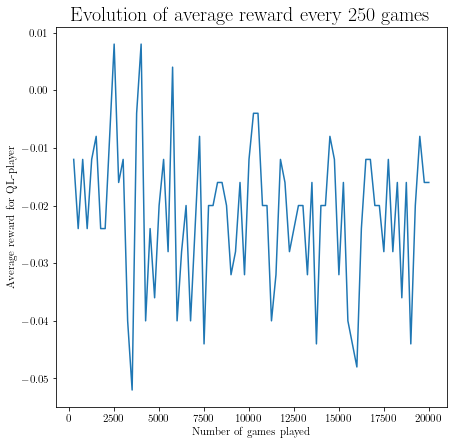

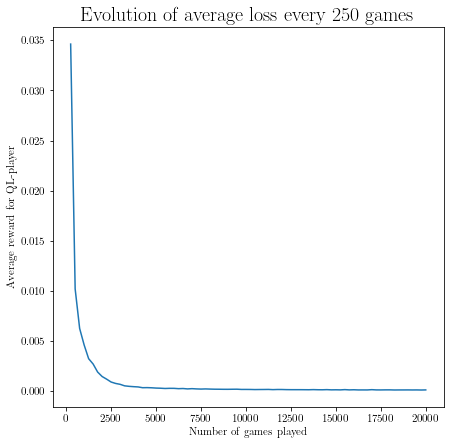

In [3]:
Q1_DQN(policy_net, target_net, memory, eps_opt = 1)

# 3.2

Q.11